# Hazard: Landslides

The `landslide` class inherits from the `hazard` class. Other than some of the hazard modules available in `climada`, the landslide module does not run a physical model in its background. Rather, this tutorial is a suggestion of how to handle two different types of hazard source files (in one case, already the finished product of some model output, in the other case just a historic data collection).

We propose 2 different types of landslide hazard datasets that the module's methods work well with: 
* *historic landslides*: historic event sets based on the NASA COOLR global landslide catalogue, continuously updated.
* *probabilistic landslides*: two raster files on probabilistic LS hazard, one for landslides triggered by precipitation and one for landslides triggered by earthquakes, based on data from the Norwegian Geotechnical Institute (NGI) for UNEP GRID, last improved 2018.

The module comes with two main functions, both delivering a raster-hazard set (once of historic occurrences, once with probabilistically sampled occurrences)
* `set_ls_hist()`
* `set_ls_prob()`

### Option 1: historic landslide events: NASA COOLR initiative
Data from the global landslide catalogue is continuously updated as part of the Cooperative Open Online Landslide Repository (https://pmm.nasa.gov/landslides/coolrdata.html#download). The data consists in points representing an approximate occurence location, without spatial extent and any kind of "intensity" (binary events).

The most recent version of the dataset should always be downloaded by going to the link > "Open Landslide Viewer" (takes some time to load) > click "Download the full Landslide Catalog" > selecting the "NASA Global Landslide Catalog Points (Shapefile)" for download.

Download and unzip the up-to-date version.

**Important**: The original file has a typo in one of its entries, which messes up the reading of a bounding box. Reading it once into memory with geopandas and re-saving it as shapefile solves this. This has to be done only once.


In [1]:
# Amending the Landslide catalog by loading and re-saving (only necessary first time!)
import geopandas as gpd

path_COOLR = 'your path to folder nasa_global_landslide_catalog_point.shp' #e.g.:'/Users/evelynm/climada_python/data/system/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'
ls_gdf_all = gpd.read_file(path_COOLR)
ls_gdf_all.to_file(path_COOLR)

Now we can start the actual task..

In [1]:
import sys
path_climada = 'your_path_to_climada_python/' #e.g.: '/Users/evelynm/climada_python/'
sys.path.append(path_climada)

In [3]:
# Loading packages
%matplotlib inline
import climada.hazard.landslide
from climada.hazard.landslide import Landslide

The historic landslide events are read into a landslide hazard set.
Since the events are reported as simple points, we convert the hazard set to a raster file with a certain resolution.
The resolution (`res`, in degrees) can be chosen such that a "reasonable" area is covered per event. e.g. 0.004 (which is about 450m at the equator).
All area within a grid cell that "hosts" an event point is hence affected. The resolution you choose may therefore drastically affect your damage calculations!

/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **style)


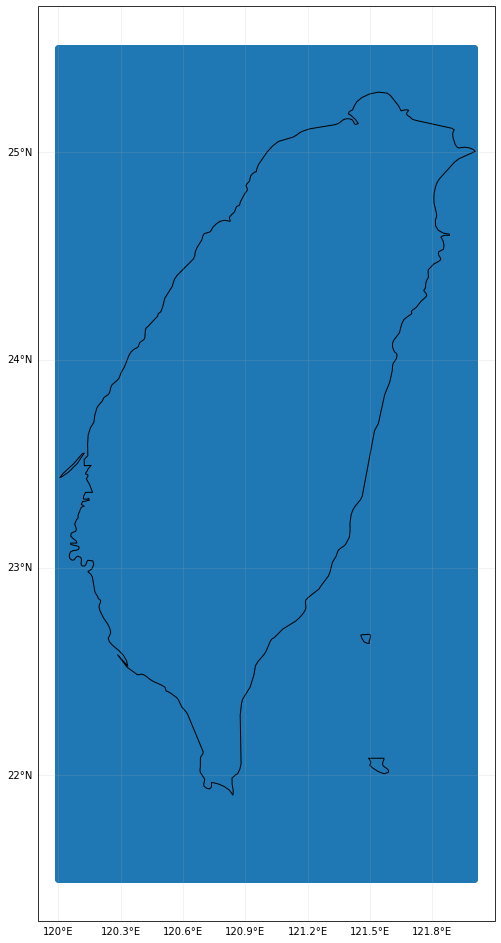

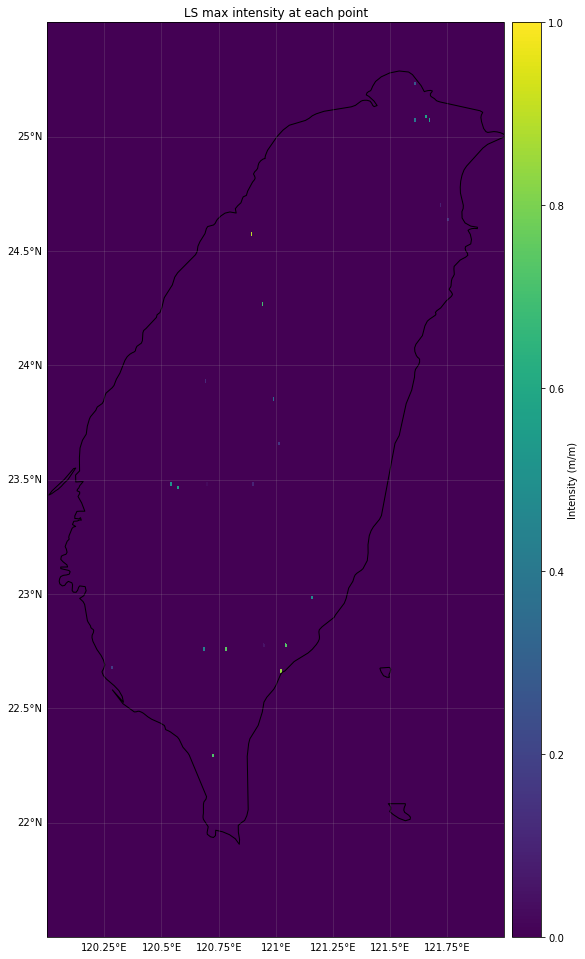

In [4]:
path_COOLR = 'your path to folder nasa_global_landslide_catalog_point.shp' #e.g.:'/Users/evelynm/climada_python/data/system/nasa_global_landslide_catalog_point/nasa_global_landslide_catalog_point.shp'
bbox_taiwan = (120.0, 21.5, 122.0, 25.5) # bbox as (minx, miny, maxx, maxy) 
# Example for Taiwan
haz_ls_Taiwan_hist = Landslide()
haz_ls_Taiwan_hist.set_ls_hist(bbox=bbox_taiwan, 
                               path_sourcefile=path_COOLR, 
                               res=0.004,
                               check_plots=True)

### Exemplary end-to-end impact calculation using the historic LS option

The steps below follow the normal routine of defining impact functions, getting an exposure, and performing an impact calculation based on the given historic hazard set.

*Impact functions* relate the hazard intensity to a percentage of damage in the exposure. For a detailed description on impact functions, check out the respective tutorial.

Since the historic landslides have no spatial extent, their intensity is simply put to "1" at the respective point of occurrence and a dummy step impact function is created for illustrative purposes, where damage (impact) is simply 100% when intensity (close to) 1, and 0 else.

In [7]:
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

2021-02-12 15:51:44,930 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


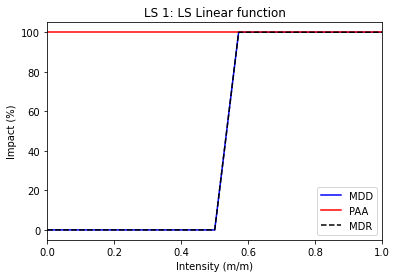

In [8]:
# Set impact function (see tutorial climada_entity_ImpactFuncSet)
if_LS_hist = ImpactFunc() 
if_LS_hist.haz_type = 'LS'
if_LS_hist.id = 1
if_LS_hist.name = 'LS Linear function'
if_LS_hist.intensity_unit = 'm/m'
if_LS_hist.intensity = np.linspace(0, 1, num=15)
if_LS_hist.mdd = np.sort(np.array([0,0,0,0,0,0,0,0,1., 1., 1., 1., 1., 1., 1.]))
if_LS_hist.paa = np.sort(np.linspace(1, 1, num=15))
if_LS_hist.check()
if_LS_hist.plot()
ifset_LS_hist = ImpactFuncSet()
ifset_LS_hist.append(if_LS_hist)

For a detailed description of the *Exposure* class, refer to the respective tutorial.
This LS tutorial uses the LitPop class, which models countries' gridded asset exposure by disaggregating a macroeconomic indicator (e.g. total asset value or GDP) proportional to the product of night light intensities ("Lit") and gridded population count ("Pop") per country.  

2021-02-12 15:51:50,304 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-02-12 15:51:59,719 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-02-12 15:52:14,927 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2021-02-12 15:52:14,928 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2021-02-12 15:52:15,446 - climada.entity.exposures.litpop - INFO - Creating the LitPop exposure took 26 s
2021-02-12 15:52:15,447 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2021-02-12 15:52:15,447 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-12 15:52:15,448 - climada.entity.exposures.base - INFO - deductible not set.
2021-02-12 15:52:15,448 - climada.entity.exposures.base - INFO - cover not set.
2021-02-12 15:52:15,449 - climada.entity.exposures.bas

/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-12 15:52:19,864 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/contextily/tile.py:268: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<

2021-02-12 15:52:47,765 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


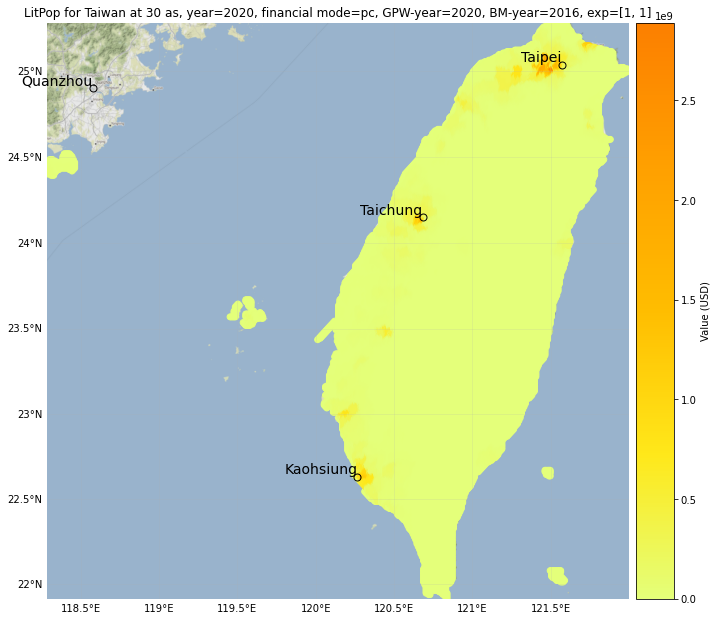

In [9]:
# Set LitPop exposure for Taiwan
exp_LS_hist = LitPop()
exp_LS_hist.set_country('Taiwan', reference_year = 2020)
exp_LS_hist.set_geometry_points()
exp_LS_hist.rename({'if_': 'if_LS'}, axis='columns')
exp_LS_hist = Exposures(exp_LS_hist)
exp_LS_hist.set_lat_lon()
exp_LS_hist.check()

# plot the exposure
exp_LS_hist.plot_basemap()

In [10]:
# Set Entity    
ent_LS_hist = Entity()
ent_LS_hist.exposures = exp_LS_hist
ent_LS_hist.impact_funcs = ifset_LS_hist

**Important note**:  Climada allows you to perform damage statistics (such as average annual impact, impact exceedance curves, etc.), since the historic events are by default assigend a certain frequency (1/return period), which is derived from 1/(the entire observation time in the reported events). Since those reported events have no guarantee of completeness, and cover a relatively short time, it is strongly advised not to do this. Apply the probabilistic method (explained below) for such calculations.

2021-02-12 15:54:37,383 - climada.engine.impact - INFO - Exposures matching centroids found in centr_LS
2021-02-12 15:54:37,388 - climada.engine.impact - INFO - Calculating damage for 45512 assets (>0) and 64 events.
2021-02-12 15:54:37,389 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2021-02-12 15:54:37,418 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333297333 to 0.008333333333297333.
The overall estimated impact from alle events is 9715876 $


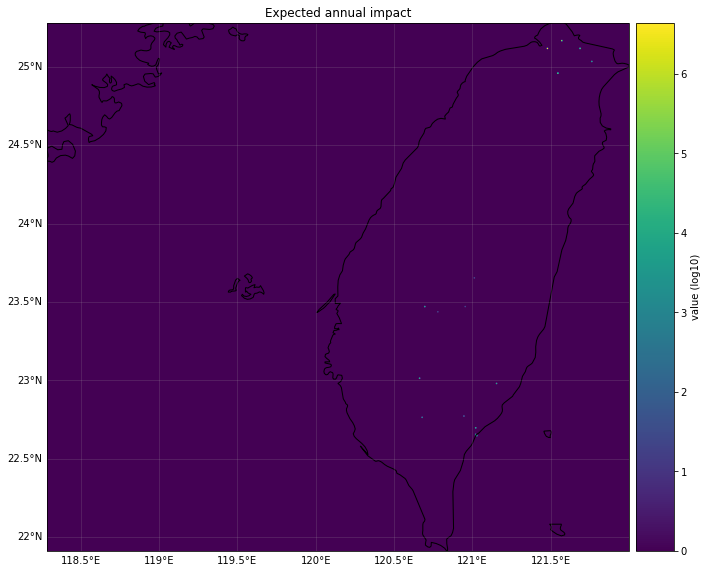

In [12]:
# Impact calculation from historic landslides, with exposure and impact function defined as above.
imp_LS_Taiwan_hist = Impact()
imp_LS_Taiwan_hist.calc(ent_LS_hist.exposures, ent_LS_hist.impact_funcs, haz_ls_Taiwan_hist)
imp_LS_Taiwan_hist.plot_raster_eai_exposure()
print(f'The overall estimated impact from all events is {int(imp_LS_Taiwan_hist.aai_agg)} $')

### Option 2:  probabilistic landslide hazard (precipitation / earthquake-induced) from UNEP / NGI

The global probabilistic hazardsets are provided publicly by UNEP GRID and were developed by the Norwegian Geotechnical Institute (NGI).

Since the webservices are currently (as of 08/20) not working, please download the geoTIFFs manually:

- Go to https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=2&lang=eng for precipitation-triggered landslides.
- Go to https://preview.grid.unep.ch/index.php?preview=data&events=landslides&evcat=1&lang=eng for earthquake-triggered landslides.
- Unzip the folder and move it to a sensible location


The datasets are in units of expected annual probability and percentage of pixel of occurrence of a potentially destructive landslide event x 1000000 and include an estimate of the annual frequency of landslide triggered by precipitation / earthquakes. It depends on the combination of trigger and susceptibility defined by six parameters: slope factor, lithological (or geological) conditions, soil moisture condition, vegetation cover, precipitation and seismic conditions.

Given how the external hazard set is defined ("expected annual probability and percentage of pixel of occurrence of a potentially destructive landslide event "), intensity and fraction are assigned a bit different from the normal hazard-reading method (but consistent with the definition in the historic set): 

Probabilistic events are produced by sampling binomially over the occurrence probabilities in each grid cell.
The "numbers of successes" are stored as fraction, intensity is 0 if there was no event in a grid cell, and 1 if at least one event occurred. Frequency is number of successes / number of years.

Read the documentation for details. 

In [5]:
# Loading packages
%matplotlib inline
import climada.hazard.landslide
from climada.hazard.landslide import Landslide

Let's produce a 500 year probabilistic event set for the same geographic extent as above.
Be aware that the resolution of the grid cells is 0.00833° (about 900m at the equator), so events tend to be quite large, if they occur.

2021-02-12 16:32:32,338 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/system/ls_pr/ls_pr.tif
2021-02-12 16:32:32,454 - climada.hazard.landslide - INFO - Sampling landslide events for a 500 year period
2021-02-12 16:32:37,916 - climada.util.coordinates - INFO - Reading /Users/evelynm/climada_python/data/system/ls_pr/ls_pr.tif
2021-02-12 16:32:38,020 - climada.hazard.centroids.centr - INFO - Convert centroids to GeoSeries of Point shapes.


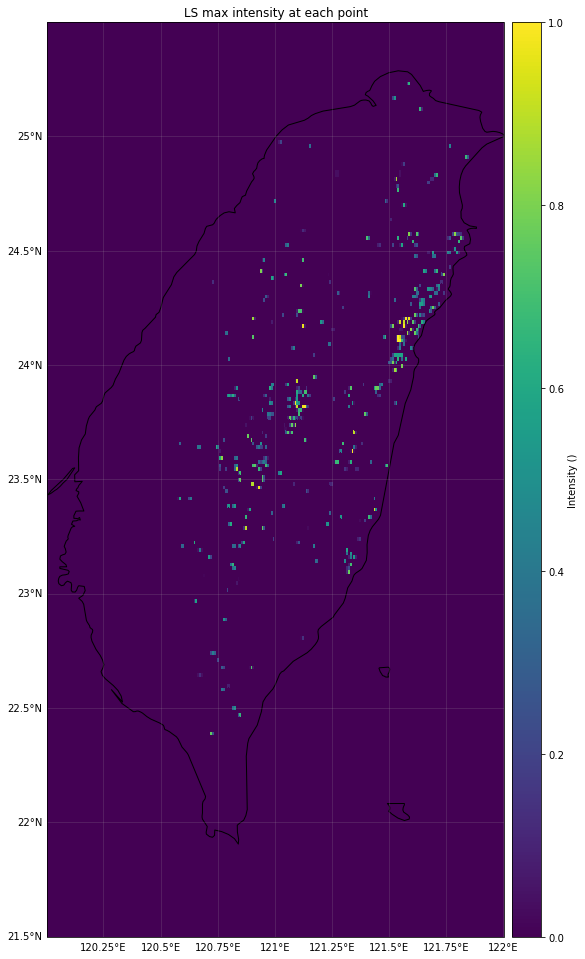

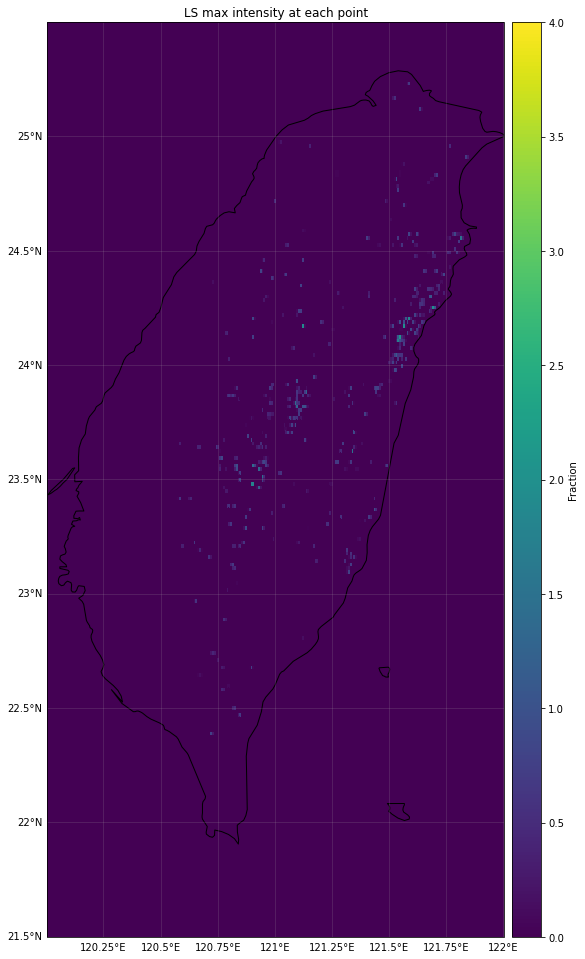

In [6]:
# Setting precipitation-triggered landslide hazard for Taiwan
haz_ls_taiwan_prob = Landslide()
bbox_taiwan = (120.0, 21.5, 122.0, 25.5)
path_lsfile = 'your path to ls_pr.tif' #e.g. '/Users/evelynm/climada_python/data/system/ls_pr/ls_pr.tif'

# The check-plots produce intensity (image 1) and fraction (image 2) plots
# a correction factor of 1 million is applied since probs are reportet as x10e6 in the original data:
haz_ls_taiwan_prob.set_ls_prob(bbox=bbox_taiwan, path_sourcefile=path_lsfile, 
                               n_years=500, corr_fact=10e6, check_plots=True)


With the hazard set loaded, it is now possible to calculate the expected damage for the simulated period:

In [7]:
from climada.entity import Exposures, Entity, LitPop
from climada.entity import ImpactFuncSet, ImpactFunc
from climada.engine import Impact
import numpy as np

/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


**Important for impact calculations**: Since impact functions act on the intensity of a hazard, an our hazard takes on binary intensity values (0 = no LS prob, 1 = >0 LS prob), it makes sense to define some step-function around those two values. The impact calculation accounts for the fractions (% of affected pixel and actual annual probability) by multiplying them into the end-result, anyways, under the hood.

2021-02-12 16:33:09,335 - climada.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


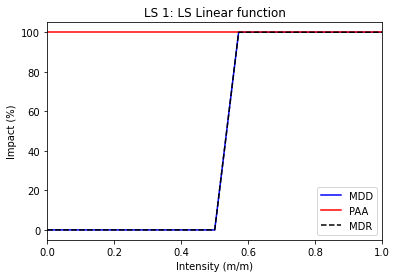

In [8]:
# Set impact function
if_LS_prob = ImpactFunc() 
if_LS_prob.haz_type = 'LS'
if_LS_prob.id = 1
if_LS_prob.name = 'LS Linear function'
if_LS_prob.intensity_unit = 'm/m'
if_LS_prob.intensity = np.linspace(0, 1, num=15)
if_LS_prob.mdd = np.sort(np.array([0,0,0,0,0,0,0,0,1., 1., 1., 1., 1., 1., 1.]))
if_LS_prob.paa = np.sort(np.linspace(1, 1, num=15))
if_LS_prob.check()
if_LS_prob.plot()
ifset_LS_prob = ImpactFuncSet()
ifset_LS_prob.append(if_LS_prob)

2021-02-12 16:33:11,561 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 30.0 arcsec.
2021-02-12 16:33:20,770 - climada.entity.exposures.gpw_import - INFO - Reference year: 2019. Using nearest available year for GWP population data: 2020
2021-02-12 16:33:20,773 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-02-12 16:33:36,995 - climada.util.finance - WARNING - No data available for country. Using non-financial wealth instead
2021-02-12 16:33:36,999 - climada.util.finance - WARNING - GDP data for TWN is not provided by World Bank.                        Instead, IMF data is returned here.
2021-02-12 16:33:37,500 - climada.entity.exposures.litpop - INFO - Creating the LitPop exposure took 27 s
2021-02-12 16:33:37,501 - climada.entity.exposures.base - INFO - Hazard type not set in if_
2021-02-12 16:33:37,501 - climada.entity.exposures.base - INFO - centr_ not set.
2021-02-12 16:33:37,502 - climada.entity.exposures.base - INFO - de

/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


2021-02-12 16:33:42,240 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/contextily/tile.py:268: FutureWarning: The url format using 'tileX', 'tileY', 'tileZ' as placeholders is deprecated. Please use '{x}', '{y}', '{z}' instead.
  FutureWarning,
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<

2021-02-12 16:34:02,566 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


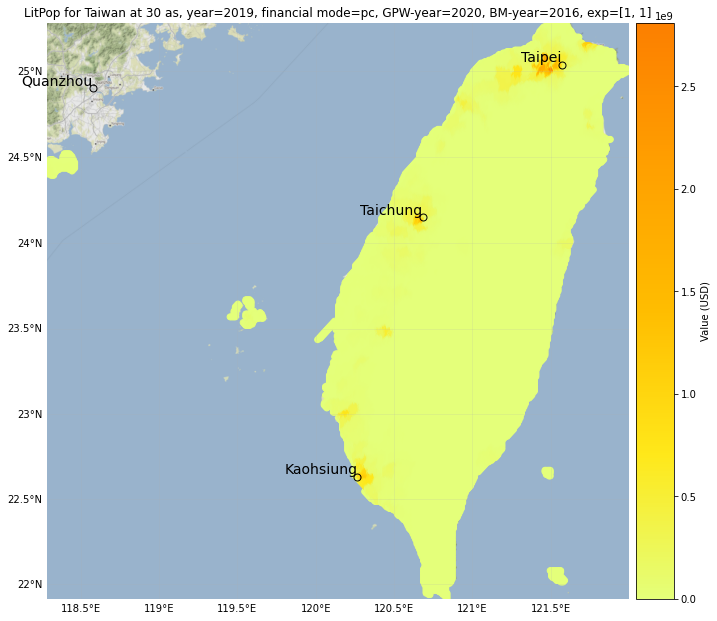

In [9]:
# Set exposure for Taiwan:
exp_LS_prob = LitPop()
exp_LS_prob.set_country('Taiwan', reference_year = 2019)
exp_LS_prob.set_geometry_points()
exp_LS_prob.rename({'if_': 'if_LS'}, axis='columns')
exp_LS_prob = Exposures(exp_LS_prob)
exp_LS_prob.set_lat_lon()
exp_LS_prob.check()

# plot exposure
exp_LS_prob.plot_basemap()

In [10]:
# Set Entity    
ent_LS_prob = Entity()
ent_LS_prob.exposures = exp_LS_prob
ent_LS_prob.impact_funcs = ifset_LS_prob

2021-02-12 16:34:12,308 - climada.entity.exposures.base - INFO - Matching 46165 exposures with 115921 centroids.
2021-02-12 16:34:12,314 - climada.engine.impact - INFO - Calculating damage for 45512 assets (>0) and 1 events.
2021-02-12 16:34:12,315 - climada.engine.impact - INFO - Missing exposures impact functions for hazard if_LS. Using impact functions in if_.
2021-02-12 16:34:12,443 - climada.util.coordinates - INFO - Raster from resolution 0.008333333333297333 to 0.008333333333297333.


/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/Users/evelynm/opt/anaconda3/envs/climada_newenv/lib/python3.7/site-packages/cartopy/mpl/feature_artist.py:215: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  **style)


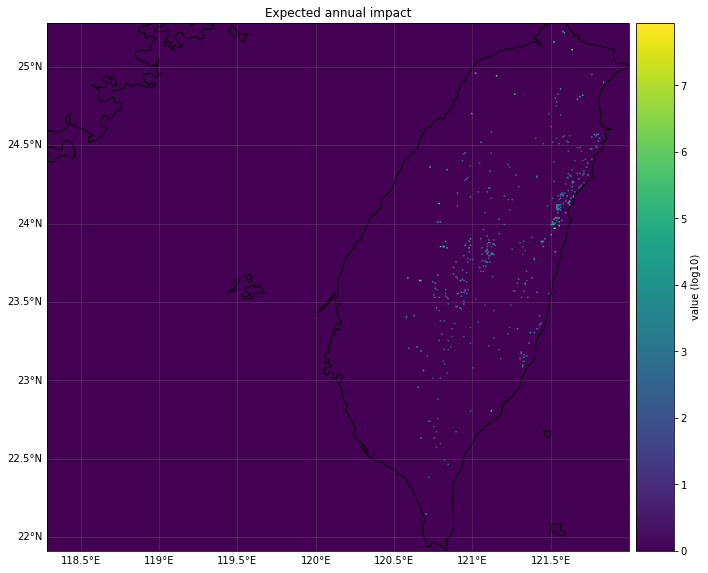

In [11]:
# Set impact for probabilistic simulation
imp_LS_Taiwan_prob_I = Impact()
imp_LS_Taiwan_prob_I.calc(ent_LS_prob.exposures, ent_LS_prob.impact_funcs, haz_ls_taiwan_prob)
imp_LS_Taiwan_prob_I.plot_raster_eai_exposure()